<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Ensemble Learning. </center></h2>

In [26]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Read Data

In [2]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [3]:
X = df_X.values
y = df_y['target'].values

In [4]:
print("X shape: ", X.shape)
X[:5]

X shape:  (25289, 12)


array([[3.90000000e+01, 1.00000000e+01, 3.00000000e+00, 1.70000000e+01,
        2.44444444e+01, 1.00000000e+00, 5.00000000e+00, 4.00000000e-01,
        2.65000000e+06, 1.37500000e+03, 2.10000000e+01, 2.00000000e+00],
       [2.10000000e+01, 2.20000000e+01, 1.90000000e+01, 5.50000000e+01,
        1.70454545e+01, 1.00000000e+00, 6.00000000e+00, 3.33333333e-01,
        5.61400000e+06, 3.82500000e+03, 5.10000000e+01, 4.00000000e+00],
       [5.00000000e+00, 6.00000000e+00, 1.00000000e+00, 6.00000000e+00,
        8.40000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        8.57000000e+05, 1.15000000e+03, 1.40000000e+01, 1.00000000e+00],
       [2.10000000e+01, 2.00000000e+00, 5.00000000e+00, 6.00000000e+00,
        1.90000000e+01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.20000000e+05, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 1.00000000e+00, 5.00000000e+00,
        9.60000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00

In [5]:
print("y shape: ", y.shape)
y[:5]

y shape:  (25289,)


array([0, 1, 1, 1, 0], dtype=int64)

# Train / Test Split

In [6]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    
                                                    random_state=123) 

# Task 1 (5 points)

Implement Random Forest classifier as it was described in your lectures:

**Input**: 
* training dataset $TDS=\{(x_{i},y_{i}),\,1=1,2,...N\}$; 
* the number of trees $B$ and the size of feature subsets $m$.

for $b=1,2,...B$:

1. generate random training dataset $TDS^{b}$ of size $N$ by sampling $(x_{i},y_{i})$ pairs from $TDS$ with replacement (bootstrap)
2. build a tree using $TDS^{b}$ training dataset with feature selection for each node from random subset of features of size $m$ (generated **individually for each node**).


**Output**: $B$ trees. Classification is done using majority vote and regression using averaging of $B$ outputs

**Hints:**
- Use decision tree classifier from sklean library. You can import it with the command: `from sklearn.tree import DecisionTreeClassifier` with `max_features` option. 
- You can use `numpy.random.choice()` function to generate random subsamples to train decition tree classifiers.

### Let' s start with small steps

#### First step

Implement auxiliary function, which generate K random subsamples (with replacement) of X, y of size N

In [7]:
def gen_subsamples(X, y, K, N):
    n_s, n_f = X.shape
    gen_x = np.empty(shape=(K, N, n_f))
    gen_y = np.empty(shape=(K, N))
    
    random_selection = []
    for i in range(K):
        random_selection.append(np.random.choice(a=range(n_s), size=N))
    
    for i in range(K):
        gen_x[i] = X[random_selection[i]]
        gen_y[i] = y[random_selection[i]]
        
    return gen_x, gen_y

#### Second step

Implement auxiliary function which get list of (X,y) with lengh K and fit K base_estimators. Each estimator fit from the corresponding sample. 

In [12]:
def fit_subsamples(subsamples, n):
    X_samples, y_samples = subsamples
    estis = []
    
    for X, y in zip(X_samples, y_samples):
        estis.append(DecisionTreeClassifier(max_features=n).fit(X, y))
        
    return estis

#### Example with multiprocessing

In [15]:
def fit(params, n):    
    X, y, size = params
    subsamples = gen_subsamples(X, y, size, X.shape[0])
    return fit_subsamples(subsamples, n)

In [16]:
import multiprocessing

process_count = 4
parts = [
    (X, y, 1000 // process_count)
    for i in range(process_count)
]

In [ ]:
with multiprocessing.Pool(process_count) as p:
    # every part is sent to separate processes
    clfs = p.map(fit, parts)

### And now combine it all together in one class

In [23]:
# You need to modify this class #

class RandomForestCalssifier(object):
    
    def __init__(self, n_trees=10, n_subset_features=2): # you can add more hyperparameters
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_trees : int
            Number of decision trees to train.
        n_subset_features : int
            Number of random features to used to train a decision tree.
        """
        
        self.n_trees = n_trees
        self.n_subset_features = n_subset_features
        
    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        self.estimators = fit((X, y, self.n_trees), self.n_subset_features)
        self.n_classes = len(set(y))
    
    
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        probabilities = np.empty(shape=(self.n_trees, X.shape[0], self.n_classes))
        
        for i, tree in enumerate(self.estimators):
            probabilities[i] = tree.predict_proba(X)
        
        return np.mean(probabilities, axis=0)
    
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        probabilities = np.empty(shape=(self.n_trees, X.shape[0], self.n_classes))
        
        for i, tree in enumerate(self.estimators):
            probabilities[i] = tree.predict_proba(X)
        
        c = range(probabilities.shape[2])
        tree_predicts = []
            
        for tree_probas in probabilities:
            tree_predicts.append([max(c, key=lambda _class: sample_probas[_class]) for sample_probas in tree_probas])
        
        labels = []
        for sample_predicts in zip(*tree_predicts):
            labels.append(max(c, key=sample_predicts.count))
            
        return labels

In [24]:
clf = RandomForestCalssifier(n_trees=10, n_subset_features=2)
clf.fit(X_train, y_train)

In [25]:
y_test_predict = clf.predict(X_test)

y_test_predict[:10]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

# Task 2 (1 point)

Plot ROC curve on the test sample for your random forest classifier. Also, claculate ROC AUC value. Use `RandomForestClassifier.predict_proba()` method.

Hints:
- You can use `sklearn.metrics.roc_curve` frunction to calculate ROC curve.
- `sklearn.metrics.roc_auc_score` function helps you to calculate ROC AUC value.

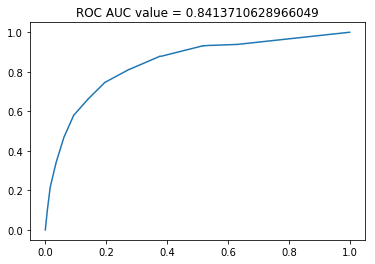

In [32]:
res_probabis = clf.predict_proba(X_test)

Rx, Ry, tmp = roc_curve(y_test, res_probabis[:, 1])
plt.plot(Rx, Ry)
plt.title('ROC AUC value = ' + str(auc(Rx, Ry)))
plt.show()

# Task 3 (2 points)

Plot dependecy of ROC AUC value from number of trees (`n_trees`) in your random forest classifier.

# Task 4 (2 points)

Plot dependecy of ROC AUC value from `n_subset_features` of your random forest classifier. Use `n_trees=100`.

In [17]:
# Your code is here